# 項目32-34

担当者：須藤

## 項目32 大きなリスト内包表記にはジェネレータ式を考える

リスト内包表記 （「項目27 `map` や `filter` の代わりにリスト内包表記を使う」参照）の問題は、入力シーケンスの各値に対してそれぞれまったく新しいリストを作りかねないことである。入力が小さければ問題ないが、入力が大きい場合、膨大な量のメモリを消費し、プログラムのクラッシュを引き起こしかねない。

例えば、ファイルを読み込んで、各行の文字数を返すとする。これをリスト内包表記で行うと、メモリにファイルの各行の長さを保持する必要がある。ファイルが非常に大きかったり、決して終わりのないネットワークソケットである場合、リスト内包表記を使うのは問題となる。次のコードは、小さな入力値だけ扱うことのできるリスト内包表記の使い方である。

In [7]:
# Example 1
import random

with open('my_file.txt', 'w') as f:
    for _ in range(10):
        f.write('a' * random.randint(0, 100))
        f.write('\n')

value = [len(x) for x in open('my_file.txt')]
print(value)

[16, 100, 42, 30, 36, 28, 33, 14, 69, 47]


この問題を解くために、Python は、リスト内包表記とジェネレータを組み合わせたジェネレータ式を提供している。ジェネレータ式はリスト内包表記と似通った構文であり、下記のように前後を `()` で括る。
ジェネレータ式はリスト内包表記と異なり、実行時に出力シーケンス全体を実際に生成することはない。ジェネレータ式の評価値はイテレータで、式から1つずつ要素を `yield` で出すことができる。
先ほど示したコードと等価なジェネレータ式を使ったものを次に示す（ただし、ジェネレータ式は直ちにイテレータとなり、単体ではそれ以上何も行わない）。


In [8]:
# Example 2
it = (len(x) for x in open('my_file.txt'))
print(it)

<generator object <genexpr> at 0x0000021046A505F0>


返されたイテレータは、必要に応じて (組み込み関数 `next` を用いて) ジェネレータ式から次の出力を生成するように、1ステップずつ進めることができる。次のコードでは、メモリ使用量が爆発する危険を冒さず、必要な分だけをジェネレータ式から取り出すように記述している。


In [9]:
# Example 3
print(next(it))
print(next(it))

16
100


ジェネレータ式のもう1つの強力な機能は組み合わせられることである。上のジェネレータ式から返されたイテレータを使って、別のジェネレータ式への入力とするコードを次に示す。

In [10]:
# Example 4
it = (len(x) for x in open('my_file.txt'))  # [77, 59, 80, 45, 57, 47, 47, 77, 2, 48]
roots = ((x, x**0.5) for x in it)

このイテレータを1つ進めるごとに、内部のイテレータも1つ進み、ループし、条件式を評価し、入力と出力を渡していくというように、あたかもドミノ倒しのような効果を生成する。


In [11]:
# Example 5
print(next(roots))
print(next(roots))

(16, 4.0)
(100, 10.0)


このような連鎖ジェネレータは、Python では極めて高速に実行される。膨大な入力ストリームを操作する機能を構成する方法として、ジェネレータ式は最適なツールである。ただし、ジェネレータ式が返すイテレータがステートフルであることを理解し、繰り返して使わないようにしなければならない（項目31 引数に対してイテレータを使うときには確実さを優先する」参照）。


### 覚えておくこと

- リスト内包表記は、大量の入力に対してはメモリを使いすぎるという問題を引き起こす。
- ジェネレータ式は、イテレータとして出力を1つずつ生成するので、メモリ問題を回避することができる。
- ジェネレータ式は、ジェネレータ式から得られたイテレータを他のジェネレータの for 部分 式に渡すことによって、 組み合わせることができる。
- ジェネレータ式は、連鎖的に組み合わせると非常に速く動作する。

## 項目33 yield from で複数のジェネレータを作る

ジェネレータにはさまざまな利点があり（項目30 リストを返さずにジェネレータを返すことを考える」参照）、多くの問題を解決できる（項目31 引数に対してイテレータを使うときには確実さを優先する」参照）。ジェネレータは非常に便利であり、多くのプログラムでジェネレータがシーケンスになった層が作られるようになっている。

例えば、画面表示プログラムでジェネレータを使ってイメージの動きをアニメーションで示すことを考える。視覚効果を考慮して、イメージが最初は素早く動き、少し止まって、それからゆっくりと動き続けるようにすることを考える。次のコードでは、このアニメーションの各部分のスクリーン上での動きを示す動き幅を `yield` する2つのジェネレータを定義している。


In [12]:
# Example 1
def move(period, speed):
    for _ in range(period):
        yield speed

def pause(delay):
    for _ in range(delay):
        yield 0

最終的なアニメーションのために、`move` と `pause` を組み合わせて、スクリーン上の移動幅のシーケンスを作る。次のコードでは、アニメーションのフェーズごとにジェネレータを呼び出し、それぞれで繰り返し、すべての移動幅を順次 `yield` していく。

In [13]:
# Example 2
def animate():
    for delta in move(4, 5.0):
        yield delta
    for delta in pause(3):
        yield delta
    for delta in move(2, 3.0):
        yield delta

上のコードでは、`move` 関数は、`period` 回数だけ、`speed` の値をジェネレーターを使って `yield` している。

1つのアニメーションジェネレータで作られているため、これらをスクリーン上で動かすことができる。

In [14]:
# Example 3
def render(delta):
    print(f'Delta: {delta:.1f}')
    # Move the images onscreen

def run(func):
    for delta in func():
        render(delta)

run(animate)

Delta: 5.0
Delta: 5.0
Delta: 5.0
Delta: 5.0
Delta: 0.0
Delta: 0.0
Delta: 0.0
Delta: 3.0
Delta: 3.0


しかしこのコードは、ジェネレータの同じような `for` 文と `yield` 式が目障りで読みづらくなっている。これはまだ3つの入れ子でしかないが、フェーズが何十にもなる複雑なアニメーションであれば理解が非常に困難となるだろう。

この問題は `yield from` 式を用いることで解決できる。ジェネレータのこの機能により、入れ子になったジェネレータが親のジェネレータに制御を戻す前に、入れ子になった子ジェネレータからすべての値を生成することができる。`yield from` を用いてアニメーション関数を書き直す。

In [15]:
# Example 4
def animate_composed():
    yield from move(4, 5.0)
    yield from pause(3)
    yield from move(2, 3.0)

run(animate_composed)

Delta: 5.0
Delta: 5.0
Delta: 5.0
Delta: 5.0
Delta: 0.0
Delta: 0.0
Delta: 0.0
Delta: 3.0
Delta: 3.0


`yield from` 文は、内側のジェネレーターからの値を直接外側のジェネレーターに渡す。このため、`animate_composed` 関数の挙動は、`animate` 関数と同じアニメーションを生成する。`yield from` 文を使用することで、より簡潔にコードを記述できる。また、内側のジェネレーターがエラーを出す場合には、外側のジェネレーターにエラーを渡すことができる。

`yield from` は入れ子のループと `yield` 式を Python インタプリタで使うボイラープレート（決まり文句）であり、性能も上がる。組み込みモジュール `timeit` を用いて小さなベンチマークを計測し、速度が向上したかを確認してみる。


In [16]:
# Example 5
import timeit

def child():
    for i in range(1_000_000):
        yield i

def slow():
    for i in child():
        yield i

def fast():
    yield from child()

baseline = timeit.timeit(
    stmt='for _ in slow(): pass',
    globals=globals(),
    number=50)
print(f'Manual nesting {baseline:.2f}s')

comparison = timeit.timeit(
    stmt='for _ in fast(): pass',
    globals=globals(),
    number=50)
print(f'Composed nesting {comparison:.2f}s')

reduction = -(comparison - baseline) / baseline
print(f'{reduction:.1%} less time')


Manual nesting 2.51s
Composed nesting 2.26s
9.9% less time


ジェネレータを使う場合、可能な限り `yield from` 式を用いるのがよい。

### 覚えておくこと

- `yield from` 式により、複数の入れ子になったジェネレータを組み合わせて1つのジェネレータにできる。
- `yield from` 式により、複数の入れ子ジェネレータを使うよりも性能の良い出力ができる。

## 項目34 sendでジェネレータにデータを注入するのは避ける

`yield` 式は、イテラブルな出力値のシーケンスを生成するジェネレータ関数を提供する（「項目30 リストを返さずにジェネレータを返すことを考える」参照）。しかし、この方式は一方通行で、ジェネレータを実行時に同時にデータを入出力双方向に処理することは一見できないように見える。このような双方向処理は、さまざまなユースケースで価値がある。 

例えば、ソフトウェアラジオを使って信号を送出するプログラムを書くとしよう。与えられた点で正弦波の近似を描く関数を使うことにする。

In [17]:
# Example 1
import math

def wave(amplitude, steps):
    step_size = 2 * math.pi / steps
    for step in range(steps):
        radians = step * step_size
        fraction = math.sin(radians)
        output = amplitude * fraction
        yield output

波形のジェネレータでイテレーションして、指定された振幅の電波信号を送ることができる。

In [18]:
# Example 2
def transmit(output):
    if output is None:
        print(f'Output is None')
    else:
        print(f'Output: {output:>5.1f}')

def run(it):
    for output in it:
        transmit(output)

run(wave(3.0, 8))


Output:   0.0
Output:   2.1
Output:   3.0
Output:   2.1
Output:   0.0
Output:  -2.1
Output:  -3.0
Output:  -2.1


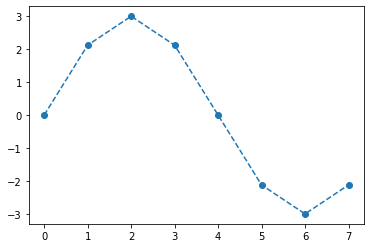

In [19]:
import matplotlib.pyplot as plt

def plot(it):
    outputs = list(it)
    plt.plot(outputs, linestyle='--', marker='o')
    plt.show()

plot(wave(3.0, 8))

基本的な波形を作るにはこれで十分だが、別の入力に基づいた波形で常に振幅を変動させること（例えば AM ラジオ信号の生成）はできない。ジェネレータのイテレーションのたびに、振幅を変調する仕組みが必要である。

Python のジェネレータには `yield` 式を双方向に使えるようにした `send` メソッドがある。`send` メソッドでは、ジェネレータが出力を `yield` しながら、ストリーム入力を受け入れられる。通常、ジェネレータをイテレーションするとき、`yield` 式の値は `None` である。


In [20]:
# Example 3
def my_generator():
    received = yield 1
    print(f'received = {received}')

it = my_generator()
output = next(it)       # Get first generator output
print(f'output = {output}')

try:
    next(it)            # Run generator until it exits
except StopIteration:
    pass
else:
    assert False

output = 1
received = None


1. `next(it)` は、ジェネレーターを開始し、最初の `yield` 文で一時停止する。1が生成される。
2. `output` に1が代入される。
3. `next(it)` は、`received` に渡す値がないため、`None` を渡す。渡された値は `yield` 文の左側に代入され、`received` に代入される。
4. `print` 文で `received` が` None` であることが確認できる。
5. ジェネレーターが終了する

`for` ループや組み込み関数 `next` でイテレーションする代わりに `send` メソッドを呼び出すと、指定した引数がジェネレータを再度呼び出したときの値になる。しかし、初めてのジェネレータでは、`yield` 式がまだないため、最初に `send` を呼び出すときに指定できるのは `None` だけである（それ以外の引数は実行時に例外が送出される）。

In [21]:
# Example 4
it = my_generator()
output = it.send(None)  # Get first generator output
print(f'output = {output}')

try:
    it.send('hello!')   # Send value into the generator
except StopIteration:
    pass
else:
    assert False

output = 1
received = hello!


1. `it.send(None)` は、ジェネレーターを開始し、最初の `yield` 文で一時停止する。1が生成される。
2. `output` に1が代入される。
3. `it.send('hello!')` は、`'hello!'` という値をジェネレーターに送信する。渡された値は `yield` 文の左側に代入され、`received` に代入される。
4. `print` 文で `received` に `'hello!'` が代入されていることが確認できる。
5. ジェネレーターが終了する。

この振る舞いを利用し、入力信号に基づいて正弦波の振幅を変調する。まず、ラジオ波のジェネ レータを `yield` 式で返された振幅を保存し、それを用いて次の出力を生成するように変更する。

In [22]:
# Example 5
def wave_modulating(steps):
    step_size = 2 * math.pi / steps
    amplitude = yield             # Receive initial amplitude
    for step in range(steps):
        radians = step * step_size
        fraction = math.sin(radians)
        output = amplitude * fraction
        amplitude = yield output  # Receive next amplitude

振幅を変調し `wave_modulating` のジェネレータにイテレーションのたびにストリーム入力するよう関数 `run` を更新する必要がある。`send` への最初の入力は、ジェネレータ内で `yield` 式が呼ばれていないので `None` でなければならない。

In [23]:
# Example 6
def run_modulating(it):
    amplitudes = [
        None, 7, 7, 7, 2, 2, 2, 2, 10, 10, 10, 10, 10]
    for amplitude in amplitudes:
        output = it.send(amplitude)
        transmit(output)

run_modulating(wave_modulating(12))

Output is None
Output:   0.0
Output:   3.5
Output:   6.1
Output:   2.0
Output:   1.7
Output:   1.0
Output:   0.0
Output:  -5.0
Output:  -8.7
Output: -10.0
Output:  -8.7
Output:  -5.0


1. `wave_modulating(12)` を呼び出すと、`amplitude` の値を受け取るためにジェネレーターが生成される。
2. `run_modulating` 関数は、`amplitudes` リストから `amplitude値` を取り出して、`it.send(amplitude)` を使用して `wave_modulating` ジェネレーターに送信する。
3. `wave_modulating` ジェネレーターは、受け取った `amplitude` 値を使用して、12回のループを実行し、それぞれのループで `output` 値を計算する。
4. `amplitude = yield output` の行では、`output` を `run_modulating` 関数に返し、次の `amplitude` の値を受け取るためにジェネレーターが一時停止する。
5. `run_modulating` 関数は次の `amplitude` 値を取り出し、再び `it.send(amplitude)` を使用してジェネレーターに送信する。
6. 2から5までのプロセスが繰り返され、`amplitudes` リストの最後の値を送信した後に `wave_modulating` ジェネレーターは終了する。

`amplitude = yield` は、最初の `yield` 文までのコードを実行するときに `yield` するということを意味している。この `yield` 文により、`run_modulating` 関数からジェネレーターに最初の値が送られ、`amplitude` 変数にその値が代入される。

出力の振幅を入力信号に基づいて変更できるようになっている。※最初の `yield` 式まではジェネレータが振幅の値を受け取っていないため、最初の出力は `None` となっている。

しかし、初めてこのコードを読む人にはかなり不適切なコードとなっている。代入文の右辺にある `yield` は直感的に理解できず、この高度なジェネレータ機能の詳細を知っていなければ、 `yield` と `send` の連携は分かりづらい。

さらに、プログラムの要求がもっと複雑になったとする。搬送波が単純な正弦波ではなく、一連の信号からなる複雑な波形を使う必要になったとしよう。これを実装する1つの方法は、`yield from` 式（項目33 `yield from` で複数のジェネレータを作る」参照）を用いて複数のジェネレータから構成される振る舞いを実装する方法である。ここでは、振幅が固定幅である単純なケースで期待通り動作することを確認する。


In [24]:
# Example 7
def complex_wave():
    yield from wave(7.0, 3)
    yield from wave(2.0, 4)
    yield from wave(10.0, 5)

run(complex_wave())

Output:   0.0
Output:   6.1
Output:  -6.1
Output:   0.0
Output:   2.0
Output:   0.0
Output:  -2.0
Output:   0.0
Output:   9.5
Output:   5.9
Output:  -5.9
Output:  -9.5


`yield from` 式が簡単な場合を扱えたので、ジェネレータの `send` メソッドでもうまくいくと思われるかもしれない。

次のコードでは、`wave_modulating` ジェネレータを複数呼び出すよう実装したものである。

In [25]:
# Example 5
def wave_modulating(steps):
    step_size = 2 * math.pi / steps
    amplitude = yield             # Receive initial amplitude
    for step in range(steps):
        radians = step * step_size
        fraction = math.sin(radians)
        output = amplitude * fraction
        amplitude = yield output  # Receive next amplitude

# Example 6
def run_modulating(it):
    amplitudes = [
        None, 7, 7, 7, 2, 2, 2, 2, 10, 10, 10, 10, 10]
    for amplitude in amplitudes:
        output = it.send(amplitude)
        transmit(output)

# Example 8
def complex_wave_modulating():
    yield from wave_modulating(3)
    yield from wave_modulating(4)
    yield from wave_modulating(5)

run_modulating(complex_wave_modulating())

Output is None
Output:   0.0
Output:   6.1
Output:  -6.1
Output is None
Output:   0.0
Output:   2.0
Output:   0.0
Output: -10.0
Output is None
Output:   0.0
Output:   9.5
Output:   5.9


これはある程度動作するが、結果には大きな問題がある。出力に多数の `None` が現れてしまっている。どうしてこうなってしまったのか。

子（`wave_modulating`）ジェネレータで `yield from` 式が終了するたびに、親（`complex_wave_modulating`）では次の`wave_modulating` ジェネレータに移る。ジェネレータの `send` メソッド呼び出しから最初の振幅を受け取るため、元の値のない `yield` 式から開始する。これにより、親ジェネレータは子のジェネレータの遷移のたびに  `None` を出力する。

これは、`yield from` と `send` を一緒に使おうとすると、それぞれの振る舞いについての仮定がうまくいかなくなることを意味している。この `None` 問題を回避するために `run_modulating` 関数を修正することはできるが、複雑であり手間がかかってしまう。また、初めてコードを読む人には `send` の動作が理解困難になっている。`yield from` によるこの状況は、それに拍車をかけてしまっている。そこで「`send` メソッドをあきらめ、より単純な方式にすること」にする。

最も簡単な解は、ラジオ波の関数にイテレータを渡すことである。組み込み関数 `next` が呼ばれるたびにイテレータは入力の振幅を返す。このようにすると、ジェネレータは入力と出力を処理しながらカスケードする（別の例は「項目32 大きなリスト内包表記にはジェネレータ式を考える」参照）。


In [26]:
# Example 9
def wave_cascading(amplitude_it, steps):
    step_size = 2 * math.pi / steps
    for step in range(steps):
        radians = step * step_size
        fraction = math.sin(radians)
        amplitude = next(amplitude_it)  # Get next input
        output = amplitude * fraction
        yield output

同じイテレータを、一緒に構成する子ジェネレータのそれぞれに渡すことができる。 イテレータはステートフルなため（項目31 引数に対してイテレータを使うときには確実さを優先する」参照）入れ子になったジェネレータは、前のジェネレータが終わったところから引き継がれる。

In [27]:
# Example 10
def complex_wave_cascading(amplitude_it):
    yield from wave_cascading(amplitude_it, 3)
    yield from wave_cascading(amplitude_it, 4)
    yield from wave_cascading(amplitude_it, 5)

振幅のリストでイテレータを渡すだけで組み合わせたジェネレータを実行できる。

In [28]:
# Example 11
def run_cascading():
    amplitudes = [7, 7, 7, 2, 2, 2, 2, 10, 10, 10, 10, 10]
    it = complex_wave_cascading(iter(amplitudes))
    for amplitude in amplitudes:
        output = next(it)
        transmit(output)

run_cascading()

Output:   0.0
Output:   6.1
Output:  -6.1
Output:   0.0
Output:   2.0
Output:   0.0
Output:  -2.0
Output:   0.0
Output:   9.5
Output:   5.9
Output:  -5.9
Output:  -9.5


この方式で最も良いのは、イテレータはどこからでもよく、完全に動的（例えば、ジェネレータ関数を使って実装）で構わない点である。唯一の欠点は、このコードでは入力ジェネレータが完全にスレッドセーフと仮定していることで、その仮定が成り立たないことがある点である。スレッド境界を超える必要がある場合、`async` 関数を用いる方が良いかもしれない（「項目62 スレッドとコルーチンを組み合わせて `asyncio` への移行を楽にする」参照）。

### 覚えておくこと

- `send` メソッドを使うと、`yield` 式に与えた値を変数に代入できるようジェネレータにデータを入力できる
- `send` と `yield from` 式を一緒に使うと、ジェネレータの出力に `None` 値が思いがけない場所に出現するようなこもった振る舞いになる
- 組み合わせたジェネレータに入力イテレータを与えるほうが、`send` メソッドを使う方式よりもよい。
